#Competition: Feedback Prize - Predicting Effective Arguments


In [1]:
pip install transformers sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.3 MB/s 
     |████████████████████████████████| 1.2 MB 52.8 MB/s 
     |████████████████████████████████| 596 kB 62.6 MB/s 
     |████████████████████████████████| 6.6 MB 51.9 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
%%shell
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c feedback-prize-effectiveness

 49% 4.00M/8.13M [00:00<00:00, 40.7MB/s]
100% 8.13M/8.13M [00:00<00:00, 73.0MB/s]


In [ ]:
!unzip /content/feedback-prize-effectiveness.zip

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!nvidia-smi

Mon Jun  6 06:01:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from transformers import AutoTokenizer,DebertaModel,AutoConfig,DebertaPreTrainedModel,get_linear_schedule_with_warmup
from sklearn.model_selection import StratifiedKFold
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
import gc
from sklearn.metrics import *

##Phrase 1: Preprocessing

In [9]:
train=pd.read_csv('train.csv')
train

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate
...,...,...,...,...,...
36760,9f63b687e76a,FFA381E58FC6,For many people they don't like only asking on...,Claim,Adequate
36761,9d5bd7d86212,FFA381E58FC6,also people have different views and opinions ...,Claim,Adequate
36762,f1b78becd573,FFA381E58FC6,Advice is something that can impact a persons ...,Position,Adequate
36763,cc184624ca8e,FFA381E58FC6,someone can use everything that many people sa...,Evidence,Ineffective


In [10]:
train[train.duplicated(['discourse_type','discourse_text','discourse_effectiveness'])]

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
1009,edf3ee8c1cee,130F9B6DCCF9,Summer projects should be teacher-designed,Position,Adequate
1552,cb2b1c856eee,1D7E734B4A3D,Summer projects should be teacher-designed,Position,Adequate
1758,690c9b7d12e8,20C01368FC3E,Summer projects should be student-designed,Position,Adequate
1932,248993ac2f7c,2352FF50900C,Summer projects should be student-designed,Position,Adequate
2643,3c57ee2d6ec6,2FF6C7542D18,Summer projects should be student-designed,Position,Adequate
3454,69ae7f51cffa,3E866ECC376A,Summer projects should be student-designed,Position,Adequate
4180,b51c95171735,4A5760917477,Summer projects should be student-designed,Position,Adequate
5190,6fbb9eb82b5c,5E9118C7949A,Summer projects should be teacher-designed,Position,Adequate
5335,899ed0d3dfc1,6198205BB70E,Summer projects should be student-designed,Position,Adequate
5571,d50c2d2f727a,66418ED2289D,Summer projects should be student-designed,Position,Adequate


In [11]:
train=train.drop_duplicates(['discourse_type','discourse_text','discourse_effectiveness'],keep='first')

In [12]:
len(train)

36707

In [13]:
train.value_counts(['discourse_effectiveness'])

discourse_effectiveness
Adequate                   20924
Effective                   9325
Ineffective                 6458
dtype: int64

In [14]:
train.value_counts(['discourse_effectiveness','discourse_type'])

discourse_effectiveness  discourse_type      
Adequate                 Claim                   7085
                         Evidence                6063
Effective                Claim                   3405
Ineffective              Evidence                3156
Effective                Evidence                2885
Adequate                 Position                2746
                         Concluding Statement    1945
Ineffective              Claim                   1473
Adequate                 Lead                    1243
                         Counterclaim            1149
Effective                Concluding Statement     825
                         Position                 769
Adequate                 Rebuttal                 693
Effective                Lead                     683
Ineffective              Concluding Statement     581
                         Position                 468
Effective                Counterclaim             418
Ineffective              Lead       

In [15]:
punctuations=list(string.punctuation)

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}


In [16]:
def normalizer(s):
  def remove_punc(text):
    chs=[]
    for ch in text:
      if ch not in punctuations:
        chs.append(ch)
      else:
        chs.append(" ")
    return "".join(chs)

  def lower(text):
    return text.lower()

  def replace_contractions(text):
    for k,v in contraction_mapping.items():
      text=text.replace(k,v)
      k=re.sub(r'\''," '",k)
      text=text.replace(k,v)
    return text

  def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)

  def white_space_fix(text):
    return ' '.join(text.split())
  
  _s=replace_contractions(s)
  _s=lower(_s)
  _s=remove_punc(_s)
  _s=remove_articles(_s)
  return white_space_fix(_s).strip()

In [17]:
len(train)

36707

In [18]:
train['norm_discourse_text']=train['discourse_text'].map(normalizer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
train['norm_discourse_type']=train['discourse_type'].map(normalizer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
train=train.drop_duplicates(['norm_discourse_type','norm_discourse_text','discourse_effectiveness'],keep='first')

In [21]:
len(train)

36598

In [22]:
train.value_counts(['discourse_effectiveness','discourse_type'])

discourse_effectiveness  discourse_type      
Adequate                 Claim                   7041
                         Evidence                6061
Effective                Claim                   3404
Ineffective              Evidence                3156
Effective                Evidence                2885
Adequate                 Position                2697
                         Concluding Statement    1945
Ineffective              Claim                   1466
Adequate                 Lead                    1242
                         Counterclaim            1149
Effective                Concluding Statement     825
                         Position                 769
Adequate                 Rebuttal                 692
Effective                Lead                     683
Ineffective              Concluding Statement     581
                         Position                 466
Effective                Counterclaim             418
Ineffective              Lead       

In [23]:
train.value_counts(['discourse_effectiveness'])

discourse_effectiveness
Adequate                   20827
Effective                   9324
Ineffective                 6447
dtype: int64

In [24]:
discourse_effectivenesses=['Ineffective','Adequate','Effective']

In [25]:
discourse_effectiveness2idx={
    'Ineffective':0,
    'Adequate':1,
    'Effective':2
}

In [26]:
train['discourse_effectiveness']=train['discourse_effectiveness'].map(discourse_effectiveness2idx)

In [27]:
train

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,norm_discourse_text,norm_discourse_type
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,1,hi i am isaac i am going to be writing about h...,lead
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,1,on my perspective i think that face is natural...,position
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,1,i think that face is natural landform because ...,claim
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,1,if life was on mars we would know by now reaso...,evidence
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,1,people thought that face was formed by alieans...,counterclaim
...,...,...,...,...,...,...,...
36760,9f63b687e76a,FFA381E58FC6,For many people they don't like only asking on...,Claim,1,for many people they do not like only asking o...,claim
36761,9d5bd7d86212,FFA381E58FC6,also people have different views and opinions ...,Claim,1,also people have different views and opinions ...,claim
36762,f1b78becd573,FFA381E58FC6,Advice is something that can impact a persons ...,Position,1,advice is something that can impact persons vi...,position
36763,cc184624ca8e,FFA381E58FC6,someone can use everything that many people sa...,Evidence,0,someone can use everything that many people sa...,evidence


In [28]:
def whitespace_tokenizer(s):
  return s.split()

In [29]:
def get_seq_len(s):
  tokens=whitespace_tokenizer(s)
  return len(tokens)

In [30]:
train['discourse_text_len']=train['norm_discourse_text'].map(get_seq_len)

In [31]:
def seq_len_visualizer(x,y):
  fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(20,20))
  ax.bar(x,y)
  fig.show()

(None, 810)

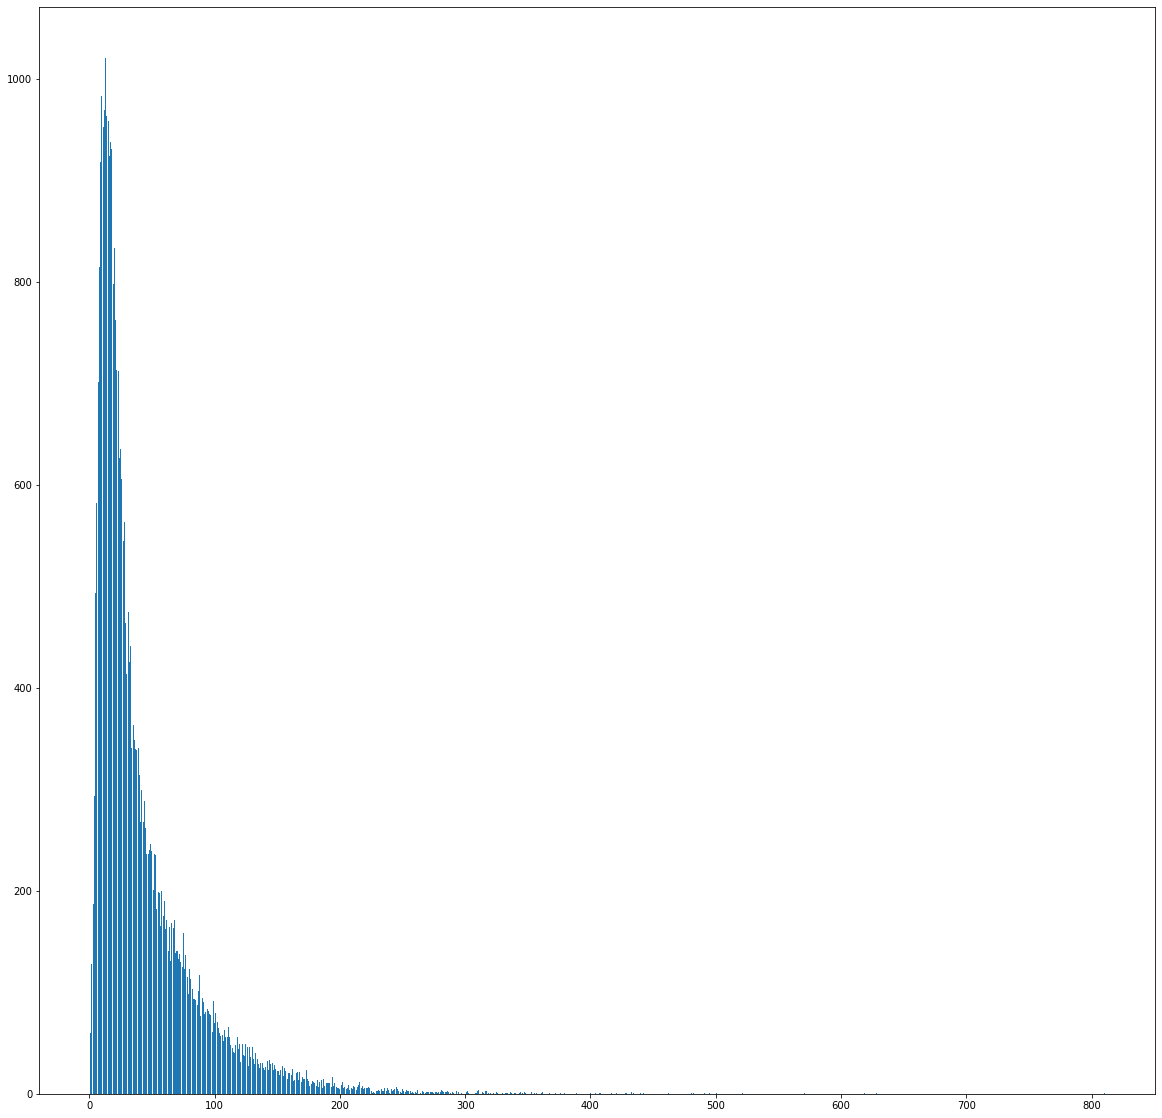

In [32]:
value_counts=train['discourse_text_len'].value_counts()
dict_occurs=value_counts.to_dict()
x,y=list(dict_occurs.keys()),list(dict_occurs.values())
seq_len_visualizer(x,y),max(x)

In [33]:
train[train['discourse_text_len']==0]

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,norm_discourse_text,norm_discourse_type,discourse_text_len


In [34]:
X=train[['norm_discourse_text','discourse_type']]
Y=train['discourse_effectiveness']

In [37]:
train.to_csv("/content/drive/MyDrive/Feedback Prize - Predicting Effective Arguments/pre_train.csv",index=False)

## Phrase 2: Load and train with Deberta + K-Fold

In [38]:
train=pd.read_csv("/content/drive/MyDrive/Feedback Prize - Predicting Effective Arguments/pre_train.csv")

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [40]:
name='microsoft/deberta-v3-base'
tokenizer=AutoTokenizer.from_pretrained(name)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/579 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [41]:
tokenizer.save_pretrained('/content/drive/MyDrive/Feedback Prize - Predicting Effective Arguments/tokenizer/')

('/content/drive/MyDrive/Feedback Prize - Predicting Effective Arguments/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Feedback Prize - Predicting Effective Arguments/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Feedback Prize - Predicting Effective Arguments/tokenizer/spm.model',
 '/content/drive/MyDrive/Feedback Prize - Predicting Effective Arguments/tokenizer/added_tokens.json',
 '/content/drive/MyDrive/Feedback Prize - Predicting Effective Arguments/tokenizer/tokenizer.json')

In [42]:
class ClassificationDataset(Dataset):
    def __init__(self, input_ids, attention_mask,labels,token_type_ids,device):
        self.labels = labels
        self.input_ids=input_ids
        self.attention_mask=attention_mask
        self.token_type_ids=token_type_ids
        self.device=device
        
    def __len__(self):
            return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        input_ids = self.input_ids[idx]
        attention_mask = self.attention_mask[idx]
        token_type_ids = self.token_type_ids[idx]
        sample = {
          "inputs":{
            "input_ids": input_ids.to(self.device),
            'attention_mask':attention_mask.to(self.device),
            'token_type_ids':token_type_ids.to(self.device),
        }, "labels": label.to(self.device)}
        
        return sample

In [43]:
def create_input(tokenizer,token_ids_0,token_ids_1=None,model_type='bert',max_length=512,padding=True):
  num_tokens_0=len(token_ids_0)
  if token_ids_1==None:
    num_tokens_1=0
  else:
    num_tokens_1=len(token_ids_1)

  if model_type=='bert':
    threshold_num_tokens_0=max_length-3-num_tokens_1
  if model_type=='roberta':
    threshold_num_tokens_0=max_length-4-num_tokens_1

  if threshold_num_tokens_0<0:
    return None
  trade_off=abs(threshold_num_tokens_0-num_tokens_0)

  if num_tokens_0>threshold_num_tokens_0:
    
    head_token_ids_0=token_ids_0[:threshold_num_tokens_0]
    tail_token_ids_0=token_ids_0[-threshold_num_tokens_0:]

    head_input_ids=tokenizer.build_inputs_with_special_tokens(head_token_ids_0,token_ids_1)
    head_token_type_ids=tokenizer.create_token_type_ids_from_sequences(head_token_ids_0,token_ids_1)
    head_attention_mask=[1]*len(head_input_ids)

    tail_input_ids=tokenizer.build_inputs_with_special_tokens(tail_token_ids_0,token_ids_1)
    tail_token_type_ids=tokenizer.create_token_type_ids_from_sequences(tail_token_ids_0,token_ids_1)
    tail_attention_mask=[1]*len(tail_input_ids)
    
    input_ids=[head_input_ids,tail_input_ids]
    token_type_ids=[head_token_type_ids,tail_token_type_ids]
    attention_mask=[head_attention_mask,tail_attention_mask]
  else:
    input_ids=tokenizer.build_inputs_with_special_tokens(token_ids_0,token_ids_1)
    token_type_ids=tokenizer.create_token_type_ids_from_sequences(token_ids_0,token_ids_1)
    attention_mask=[1]*len(input_ids)

    if padding==True:
      input_ids=input_ids+[tokenizer.pad_token_id]*trade_off
      attention_mask=attention_mask+[0]*trade_off
      token_type_ids=token_type_ids+[0]*trade_off

    input_ids=[input_ids]
    attention_mask=[attention_mask]
    token_type_ids=[token_type_ids]

  return input_ids,attention_mask,token_type_ids

In [44]:
def create_inputs(tokenizer,list_sentences_0,list_sentences_1,list_labels,model_type='bert',max_length=512):
  
  input_ids=[]
  labels=[]
  bar=tqdm(list_sentences_0)
  attention_mask=[]
  token_type_ids=[]
  num_training_samples=len(list_sentences_0)
  for i in range(num_training_samples):
    token_ids_0=tokenizer.encode(list_sentences_0[i],add_special_tokens=False)
    if list_sentences_1==None:
      token_ids_1=None
    else:
      token_ids_1=tokenizer.encode(list_sentences_1[i],add_special_tokens=False)
    _input_ids,_attention_mask,_token_type_ids=create_input(tokenizer,token_ids_0,token_ids_1,model_type,max_length)
    
    _labels=[list_labels[i]]*len(_input_ids)
    labels+=_labels
    input_ids+=_input_ids
    attention_mask+=_attention_mask
    token_type_ids+=_token_type_ids
    bar.update()  
  return {
    'input_ids':torch.Tensor(input_ids).to(torch.long),
    'attention_mask':torch.Tensor(attention_mask).to(torch.int64),
    'token_type_ids':torch.Tensor(token_type_ids).to(torch.int64),
    'labels':torch.Tensor(labels).to(torch.long)}

In [45]:
def create_dataloader(tokenizer,list_sentences_0,list_sentences_1,list_labels,model_type='bert',max_length=512,batch_size=32,drop_last=False,shuffle=True,device='cpu'):
  dataloader=create_inputs(tokenizer,list_sentences_0,list_sentences_1,list_labels,model_type,max_length)
  
  dataloader=ClassificationDataset(**dataloader,device=device)
  dataloader=DataLoader(dataloader,batch_size=batch_size,drop_last=drop_last,shuffle=shuffle)
  return dataloader

In [46]:
class DebertaModel4LastLayersForClassification(DebertaPreTrainedModel):
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config
        self.hidden_size=config.hidden_size
        self.rembert = DebertaModel(config)

        self.classifier = nn.Linear(self.config.hidden_size*4, self.config.num_labels)
        
        # Initialize weights and apply final processing
        self.init_weights()

    
    def forward(self,input_ids,attention_mask,token_type_ids,labels=None):

        outputs = self.rembert(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids,output_hidden_states=True)
        last_layers=torch.stack(outputs.hidden_states[-4:])
        last_layers=last_layers.permute(1,2,0,3)
        features=torch.flatten(last_layers,start_dim=2)
        cls_embedding=features[:,0,:]
        
        logits = self.classifier(cls_embedding)

        return logits

In [47]:
num_labels=3
num_labels

3

In [48]:
config=AutoConfig.from_pretrained(name)
config.num_labels=num_labels
config

DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.19.2",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

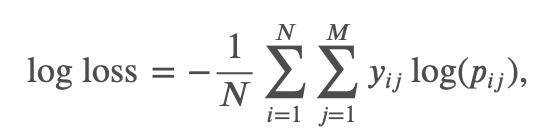

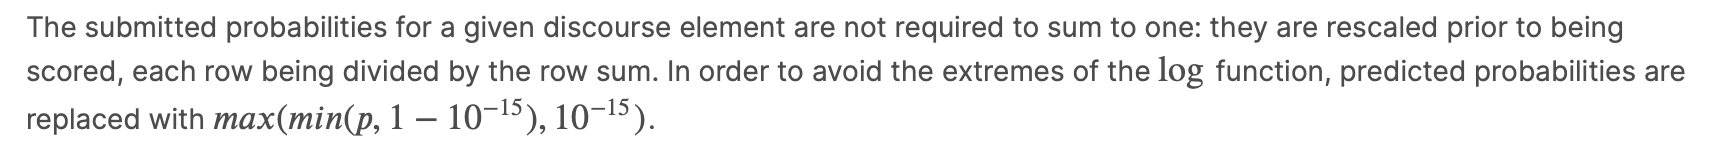

In [49]:
config.save_pretrained('/content/drive/MyDrive/Feedback Prize - Predicting Effective Arguments/config/')

In [50]:
def loss_fn(y_pred,y_true,num_classes):
  # y_pred is parsed to already log softmax function

  target=torch.nn.functional.one_hot(y_true,num_classes=num_classes)
  # min_val=torch.Tensor([1-1e-15]).to(torch.float64)
  # max_val=torch.Tensor([1e-15]).to(torch.float64)
  # probs=torch.where(y_pred>min_val,min_val,y_pred)
  # probs=torch.where(y_pred>max_val,y_pred,max_val)
  
  loss=-torch.sum(torch.sum(target*y_pred,dim=-1),dim=-1)/len(target)
  return loss

In [51]:
def run_train(model,optimizer,dataloader,lr_scheduler=None):
  model.train(True)

  loop = tqdm(dataloader)
  loss=0
  true=[]
  pred=[]
  for batch in dataloader:
    optimizer.zero_grad()
    inputs=batch['inputs']
    inputs.update({"labels":batch['labels']})
    labels=batch['labels']
    true+=labels.tolist()

    logits=model(**inputs)
    probs=torch.nn.functional.log_softmax(logits,dim=-1)

    _loss=loss_fn(probs, labels,num_classes=num_labels)
    _loss.backward()
    loss+=_loss.item()

    _pred=torch.argmax(probs,dim=-1).tolist()
    pred+=_pred
    
    optimizer.step()
    if lr_scheduler!=None:
      lr_scheduler.step()
    loop.set_postfix({f'train_loss_per_batch':_loss.item()})
    loop.update()      
  acc=accuracy_score(true,pred)
  return loss/len(dataloader),acc

In [52]:
def run_valid(model,dataloader):
  model.eval()
  loss=0
  pred=[]
  true=[]
  with torch.no_grad():
    for batch in dataloader:
      inputs=batch['inputs']
      inputs.update({"labels":batch['labels']})
      labels=batch['labels']
      true+=labels.tolist()

      logits=model(**inputs)
      probs=torch.nn.functional.log_softmax(logits,dim=-1)

      _loss=loss_fn(probs, labels,num_classes=num_labels)
      loss+=_loss.item()

      _pred=torch.argmax(probs,dim=-1).tolist()
      pred+=_pred
      
  acc=accuracy_score(true,pred)

  return loss/len(dataloader),acc

In [53]:
from os.path import join
import os

In [54]:
def save_model(epoch,model,optimizer,scheduler,training_loss,valid_loss,train_acc,valid_acc,path,step=None):
  torch.save({
          'epoch': epoch,
          'model_state_dict': model,
          'optimizer_state_dict': optimizer,
          'scheduler_state_dict': scheduler,
          'training_loss': training_loss,
          'valid_loss': valid_loss,
          'train_acc': train_acc,
          'valid_acc': valid_acc,
          'step':step
          }, join(path,'ckpt.pt'))

In [55]:
gc.collect()

26822

In [56]:
X=train[['norm_discourse_text','discourse_type']]
Y=train['discourse_effectiveness']

In [57]:
model_directory=join('/content/drive/MyDrive/Feedback Prize - Predicting Effective Arguments/models')
model_directory

'/content/drive/MyDrive/Feedback Prize - Predicting Effective Arguments/models'

In [58]:
os.makedirs(model_directory,exist_ok=True)

In [ ]:
k=5
train_batch_size=8
valid_batch_size=8
max_length=256
splits = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=123).split(X,Y))
for fold, (train_idx, valid_idx) in enumerate(splits):
  
  model_fold_directory=f'{model_directory}/model_{str(fold)}'
  os.makedirs(model_fold_directory,exist_ok=True)

  train_x=X.iloc[train_idx]
  train_y=Y.iloc[train_idx]
  sub_train=pd.concat([train_x,train_y],axis=1)
  sub_train.to_csv(f'{model_fold_directory}/train.csv',index=False)
  valid_x=X.iloc[valid_idx]
  valid_y=Y.iloc[valid_idx]
  sub_valid=pd.concat([valid_x,valid_y],axis=1)
  sub_valid.to_csv(f'{model_fold_directory}/valid.csv',index=False)

  train_dataloader=create_dataloader(tokenizer=tokenizer,list_sentences_0=train_x['norm_discourse_text'].tolist(),
                                     list_sentences_1=train_x['discourse_type'].tolist(),
                                     list_labels=train_y.tolist(),
                                     max_length=max_length,batch_size=train_batch_size,device=device)
  
  valid_dataloader=create_dataloader(tokenizer=tokenizer,list_sentences_0=valid_x['norm_discourse_text'].tolist(),
                                     list_sentences_1=valid_x['discourse_type'].tolist(),
                                     list_labels=valid_y.tolist(),
                                     max_length=max_length,batch_size=valid_batch_size,device=device)
  init_lr=1e-5
  eps=1e-8
  epochs=4
  num_training_steps=epochs*len(train_dataloader)
  num_warmup_steps=200
  model=DebertaModel4LastLayersForClassification.from_pretrained(name,config=config).to(device)

  optimizer=torch.optim.AdamW(model.parameters(),lr=init_lr,weight_decay =0.01,eps=eps)
  lr_scheduler=get_linear_schedule_with_warmup(optimizer,num_warmup_steps=num_warmup_steps,num_training_steps=num_training_steps,)


  best_acc=0
  for epoch in range(epochs):

    train_loss,train_acc=run_train(model,optimizer,train_dataloader,lr_scheduler)
    
    valid_loss,valid_acc=run_valid(model,valid_dataloader)

    
    print(f'epoch: {epoch} train_loss: {train_loss} valid_loss: {valid_loss} train_acc: {train_acc} valid_acc: {valid_acc}')
    if best_acc<valid_acc:
      
      save_model(epoch,model.state_dict(),optimizer.state_dict(),lr_scheduler,train_loss,valid_loss,train_acc,valid_acc,model_fold_directory)
      best_acc=valid_acc
  
  del model
  gc.collect()
  


  0%|          | 0/29278 [00:00<?, ?it/s]

  0%|          | 0/7320 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/354M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaModel4LastLayersForClassification: ['deberta.encoder.layer.0.output.LayerNorm.weight', 'deberta.encoder.layer.4.attention.self.query_proj.bias', 'deberta.encoder.layer.5.attention.self.key_proj.weight', 'deberta.encoder.layer.0.attention.self.query_proj.bias', 'deberta.encoder.layer.2.attention.self.value_proj.bias', 'deberta.encoder.layer.3.attention.self.query_proj.weight', 'deberta.encoder.layer.5.output.dense.weight', 'lm_predictions.lm_head.bias', 'deberta.encoder.layer.5.attention.output.dense.bias', 'deberta.encoder.layer.1.attention.self.value_proj.weight', 'deberta.encoder.layer.2.attention.output.dense.bias', 'deberta.encoder.layer.2.output.LayerNorm.weight', 'deberta.encoder.layer.2.intermediate.dense.bias', 'deberta.encoder.layer.5.intermediate.dense.weight', 'deberta.encoder.layer.4.attention.self.value_proj.weight', 'deberta.encoder.layer.3.attention.self.value_proj.bi

  0%|          | 0/3679 [00:00<?, ?it/s]

## Phrase 3: Submission

In [ ]:
test=pd.read_csv('/kaggle/input/feedback-prize-effectiveness/test.csv')
test

In [ ]:
torch.Tensor([1-1e-15]).to(torch.float32)

tensor([1.])

In [ ]:
test=test[['discourse_id','discourse_text','discourse_type']]
test

In [ ]:
model=DebertaModel4LastLayersForClassification.from_pretrained(name,config=config).to(device)

In [ ]:
checkpoint = torch.load(f'{model_fold_directory}/ckpt.pt',map_location=device)

In [ ]:
checkpoint['valid_loss']

In [ ]:
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
def predict(discourse_texts,discourse_types,max_length,return_tensors='pt',device='cpu',normalizer=None):
  model.to(device)
  model.eval()
  y_pred=[]
  with torch.no_grad():
    loop = tqdm(range(len(discourse_texts)))
    for idx,sample in enumerate(zip(discourse_texts,discourse_types)):
      if normalizer!=None:
        discourse_text=normalizer(sample[0])
      discourse_type=sample[1]
      token_ids_0=tokenizer.encode(discourse_text,add_special_tokens=False)
      token_ids_1=tokenizer.encode(discourse_type,add_special_tokens=False)
      input_ids,attention_mask,token_type_ids=create_input(tokenizer,token_ids_0,token_ids_1,max_length=max_length,padding=False)
      inputs= {
        'input_ids':torch.Tensor(input_ids).to(torch.long).to(device),
        'attention_mask':torch.Tensor(attention_mask).to(torch.int).to(device),
        'token_type_ids':torch.Tensor(token_type_ids).to(torch.int).to(device)
      }
      logits=model(**inputs)

      logits=torch.sum(logits,dim=0,keepdim=True)

      probs=torch.nn.functional.softmax(logits,dim=-1)
      y_pred.append(probs)
      loop.update()
  return torch.concat(y_pred,dim=0)

In [ ]:
y_pred=predict(test['discourse_text'].tolist(),test['discourse_type'].tolist(),max_length,device='cpu',normalizer=normalizer)

In [ ]:
ids=test['discourse_id']

In [ ]:
pred=pd.DataFrame(y_pred.tolist(),columns=discourse_effectivenesses)

In [ ]:
submit=pd.concat([ids,pred],axis=1)
submit

In [ ]:
open('submission.csv','r').read()

In [ ]:
sub=pd.read_csv("/kaggle/input/feedback-prize-effectiveness/sample_submission.csv")
sub

In [ ]:
submit.to_csv('submission.csv', index=False)

## For crash GPU case

In [ ]:
# from sklearn.model_selection import train_test_split
# train_x,valid_x,train_y,valid_y=train_test_split(X,Y,train_size=0.9,random_state=123,shuffle=True)

# max_length=256
# train_batch_size=8
# valid_batch_size=8

# model_fold_directory=f'{model_directory}/model'
# os.makedirs(model_fold_directory,exist_ok=True)


# train_dataloader=create_dataloader(tokenizer=tokenizer,list_sentences_0=train_x['norm_discourse_text'].tolist(),
#                                  list_sentences_1=train_x['discourse_type'].tolist(),
#                                  list_labels=train_y.tolist(),
#                                  max_length=max_length,batch_size=train_batch_size,device=device)

# valid_dataloader=create_dataloader(tokenizer=tokenizer,list_sentences_0=valid_x['norm_discourse_text'].tolist(),
#                                  list_sentences_1=valid_x['discourse_type'].tolist(),
#                                  list_labels=valid_y.tolist(),
#                                  max_length=max_length,batch_size=valid_batch_size,device=device)

# model=DebertaModel4LastLayersForClassification.from_pretrained(name,config=config).to(device)

In [ ]:
# init_lr=1e-5
# eps=1e-8
# epochs=4
# num_training_steps=epochs*len(train_dataloader)
# num_warmup_steps=200
# optimizer=torch.optim.AdamW(model.parameters(),lr=init_lr,weight_decay =0.01,eps=eps)

# lr_scheduler=get_linear_schedule_with_warmup(optimizer,num_warmup_steps=num_warmup_steps,num_training_steps=num_training_steps,)

# best_acc=0
# #   count_stopping=0
# for epoch in range(epochs):

#     train_loss,train_acc=run_train(model,optimizer,train_dataloader,lr_scheduler)
    
#     valid_loss,valid_acc=run_valid(model,valid_dataloader)

# #     train_loss_per_epoch.append(train_loss)
# #     valid_loss_per_epoch.append(valid_loss)

# #     train_acc_per_epoch.append(train_acc)
# #     valid_acc_per_epoch.append(valid_acc)
    
#     print(f'epoch: {epoch} train_loss: {train_loss} valid_loss: {valid_loss} train_acc: {train_acc} valid_acc: {valid_acc}')
#     # if valid_loss<min_loss:
#     if best_acc<valid_acc:
#       # min_loss=valid_loss
      
#       save_model(epoch,model.state_dict(),optimizer.state_dict(),lr_scheduler.state_dict(),train_loss,valid_loss,train_acc,valid_acc,model_fold_directory)
#       best_acc=valid_acc

# #       count_stopping=0
# #     else:
# #       count_stopping+=1
    
# #     if count_stopping>5:
# #       break
  
